#### Extracting word clouds from the pre-processed survey results

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import numpy as np

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# read the survey results
df = pd.read_csv('Preprocessed_SurveyResults.csv')
df.head()

,id,stress_level,covid_related,treating_a_covid_patient,patient_in_crisis,patient_or_patients_family,doctors_or_colleagues,administration_lab_pharmacy_radiology_or_other_ancilliary_services,increased_workload,technology_related_stress,...,saftey_physical_or_physiological_threats,work_environment_physical_or_others:_work_processes_or_procedures,description,start_timestamp,end_timestamp,duration_seconds,na_entry_before_count,na_entry_before_duration,na_entry_after_count,na_entry_after_duration
0,5C,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,NaN,1586903460,1586905080,1620,0,0,0,0
1,5C,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,1586955600,1586959200,3600,0,0,0,0
2,E4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,Was trying to get organized after being pulled...,1587215700,1587216240,540,0,0,0,0
3,E4,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,Was assessing a COVID patient who required a l...,1587220320,1587220680,360,0,0,0,0
4,7A,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,NaN,1587235920,1587236580,660,0,0,0,0


#### Defining sub-categories for keywords in description provided by nurses for specific stress events

In [9]:
categories = {
    'staff_crisis': [
        'staff shortage', 'not enough staff', 'staff issues', 'staff crisis',
        'staff concerns', 'staff members', 'staffing', 'short staffed',
        'staff problems', 'staff needs', 'staffing issues', 'staffing problems'
    ],
    'covid_related': [
        'covid unit', 'covid patient', 'covid care', 'covid testing',
        'covid cases', 'covid volume', 'covid staff', 'covid unit',
        'covid patients', 'covid symptoms', 'covid diagnosis'
    ],
    'patient_care': [
        'patient care', 'patient needs', 'patient family', 'patient crisis',
        'patient decline', 'patient status', 'patient condition', 'patient transfer',
        'patient assessment', 'patient monitoring', 'patient safety'
    ],
    'family_matters': [
        'family members', 'family concerns', 'family updates', 'family communication',
        'family support', 'family needs', 'family issues', 'family matters',
        'family contact', 'family updates', 'family care'
    ],
    'workload': [
        'increased workload', 'heavy workload', 'work load', 'work pressure',
        'work demands', 'work stress', 'work issues', 'work problems',
        'work challenges', 'work responsibilities'
    ],
    'technical_issues': [
        'technical problems', 'equipment issues', 'system problems', 'device issues',
        'technical difficulties', 'equipment problems', 'system issues',
        'technical challenges', 'equipment failure'
    ],
    'emotional_stress': [
        'emotional stress', 'emotional support', 'emotional challenges',
        'emotional impact', 'emotional burden', 'emotional strain',
        'emotional pressure', 'emotional toll'
    ],
    'communication': [
        'communication issues', 'communication problems', 'communication challenges',
        'communication needs', 'communication barriers', 'communication breakdown',
        'communication difficulties'
    ]
}

# categories and their corresponding columns(binary state) mapping 
category_columns = {
    'staff_crisis': ['lack_of_supplies', 'increased_workload'],
    'covid_related': ['covid_related', 'treating_a_covid_patient'],
    'patient_care': ['patient_in_crisis', 'documentation', 'competency_related_stress'],
    'family_matters': ['patient_or_patients_family'],
    'workload': ['increased_workload', 'documentation'],
    'technical_issues': ['technology_related_stress', 'work_environment_physical_or_others:_work_processes_or_procedures'],
    'emotional_stress': ['saftey_physical_or_physiological_threats'],
    'communication': ['doctors_or_colleagues', 'administration_lab_pharmacy_radiology_or_other_ancilliary_services']
}

In [10]:
# define stress level mapping with name
stress_level_names = {
    0.0: '0: No Stress',
    1.0: '1: Some Stress',
    2.0: '2: High Stress'
}

# define colors for stress levels for barplots
stress_level_colors = {
    0.0: '#778899',  #  No Stress
    1.0: '#a4d3ee',  #  Some Stress
    2.0: '#f08080'   #  High Stress
}

In [11]:
# get the set of all words according to category
def get_all_categorized_words():
    all_words = set()
    for category_keywords in categories.values():
        all_words.update(category_keywords)
    return all_words

In [12]:
# get the uncategorized words
def get_uncategorized_words(text, categorized_words):
    if pd.isna(text):
        return []
    
    # tokenize the text
    words = word_tokenize(text.lower())
    
    # filter out stopwords and common words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words and len(word) > 2]
    
    # Get words that don't belong to any category and exclude words that appear in any category keywords
    uncategorized = []
    for word in words:
  
        is_in_category = False
        for category_keywords in categories.values():
            if any(word in keyword or keyword in word for keyword in category_keywords):
                is_in_category = True
                break
        if not is_in_category:
            uncategorized.append(word)
    
    return uncategorized

In [13]:
def categorize_description(text, row):
    if pd.isna(text):
        return []
    
    text = str(text).lower()
    # set to avoid duplicates
    matched_categories = set()  
    
    # checking text-based categorization extracted from description column
    for category, keywords in categories.items():
        if any(keyword in text for keyword in keywords):
            matched_categories.add(category)
    
    # checking binary columns from survey results
    for category, columns in category_columns.items():
        if any(row[col] == 1.0 for col in columns):
            matched_categories.add(category)
    
    return list(matched_categories)

In [14]:
# cleaning text for wordcloud
def clean_text(text):
    if pd.isna(text):
        return ""
    # convert to lowercase
    text = str(text).lower()
    # remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # remove extra whitespace
    text = ' '.join(text.split())
    return text

In [46]:
# create wordcloud function
def create_category_wordcloud(category_counts, uncategorized_counts, ax, title, color='viridis'):
    
    # creating the dictionary of category names and counts
    word_freq = {cat.replace('_', ' ').title(): count for cat, count in category_counts.items()}
    
    # adding uncategorized words
    word_freq.update(uncategorized_counts)
    
    # generating a word cloud image
    wordcloud = WordCloud(width=800, height=600, 
                         background_color='white',
                         colormap=color,
                         max_words=100,
                         min_font_size=10).generate_from_frequencies(word_freq)
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title)

In [47]:
# cleaning and categorizing the description column
df['clean_description'] = df['description'].apply(clean_text)
df['categories'] = df.apply(lambda row: categorize_description(row['description'], row), axis=1)

# getting all categorized words
categorized_words = get_all_categorized_words()

# extracting unique stress levels
stress_levels = df['stress_level'].unique()
stress_levels.sort()

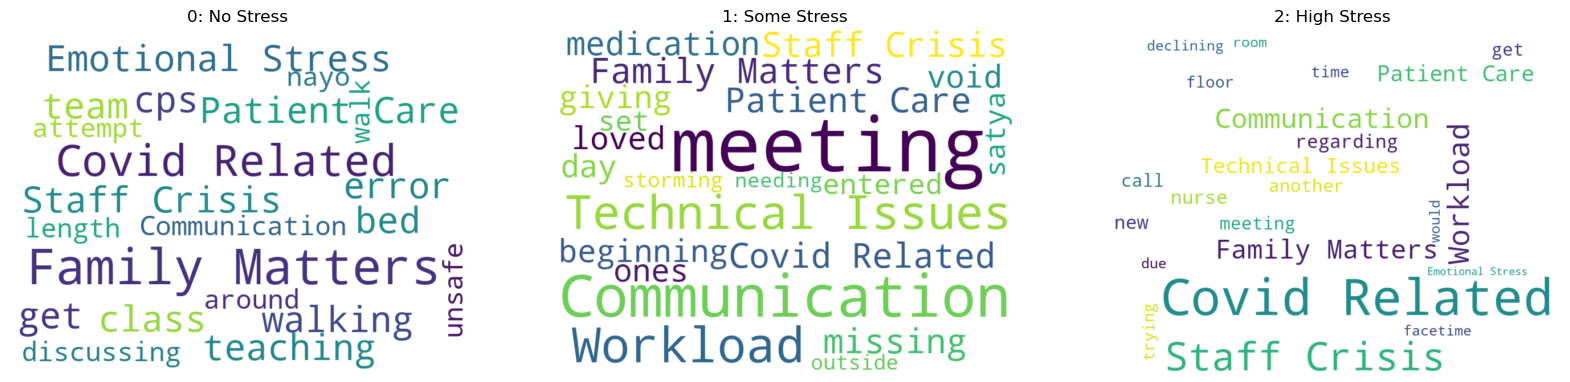

In [50]:
# figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# creating word clouds for each stress level
for idx, level in enumerate(stress_levels):
   
    level_df = df[df['stress_level'] == level]
    
    # counting categories for this stress level
    category_counts = {}
    for category_list in level_df['categories']:
        for category in category_list:
            category_counts[category] = category_counts.get(category, 0) + 1
    
    # counting uncategorized words
    uncategorized_counts = {}

    for text in level_df['clean_description']:
        uncategorized_words = get_uncategorized_words(text, categorized_words)
        for word in uncategorized_words:
            uncategorized_counts[word] = uncategorized_counts.get(word, 0) + 1
    
    # sorting uncategorized words by frequency and keeping only top 10
    uncategorized_counts = dict(sorted(uncategorized_counts.items(), key=lambda x: x[1], reverse=True)[:15])
    
    # creating word cloud in the corresponding subplot
    create_category_wordcloud(category_counts, uncategorized_counts, axes[idx], f'{stress_level_names[level]}')

#plt.tight_layout()
plt.show()

In [54]:
# category distribution for each stress level
print("\nCategory Distribution by Stress Level:")
print("-" * 50)

for level in stress_levels:
    level_df = df[df['stress_level'] == level]
    print(f"\n{stress_level_names[level]}:")
    
    # count categories
    category_counts = {}
    for category_list in level_df['categories']:
        for category in category_list:
            category_counts[category] = category_counts.get(category, 0) + 1
    
    # sorting categories
    for category, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"{category}: {count} occurrences")
    print("-" * 30)


Category Distribution by Stress Level:
--------------------------------------------------

0: No Stress:
family_matters: 4 occurrences
covid_related: 3 occurrences
patient_care: 2 occurrences
staff_crisis: 2 occurrences
emotional_stress: 2 occurrences
communication: 1 occurrences
------------------------------

1: Some Stress:
communication: 3 occurrences
workload: 2 occurrences
technical_issues: 2 occurrences
family_matters: 1 occurrences
covid_related: 1 occurrences
patient_care: 1 occurrences
staff_crisis: 1 occurrences
------------------------------

2: High Stress:
covid_related: 65 occurrences
staff_crisis: 35 occurrences
workload: 17 occurrences
communication: 15 occurrences
family_matters: 14 occurrences
patient_care: 10 occurrences
technical_issues: 9 occurrences
emotional_stress: 2 occurrences
------------------------------


In [55]:
# overall category distribution
print("\nStress incidents distributed by stress level")
print("-" * 50)
overall_counts = {}
for category_list in df['categories']:
    for category in category_list:
        overall_counts[category] = overall_counts.get(category, 0) + 1

for category, count in sorted(overall_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{category}: {count} occurrences")


Stress incidents distributed by stress level
--------------------------------------------------
covid_related: 69 occurrences
staff_crisis: 38 occurrences
family_matters: 19 occurrences
communication: 19 occurrences
workload: 19 occurrences
patient_care: 13 occurrences
technical_issues: 11 occurrences
emotional_stress: 4 occurrences


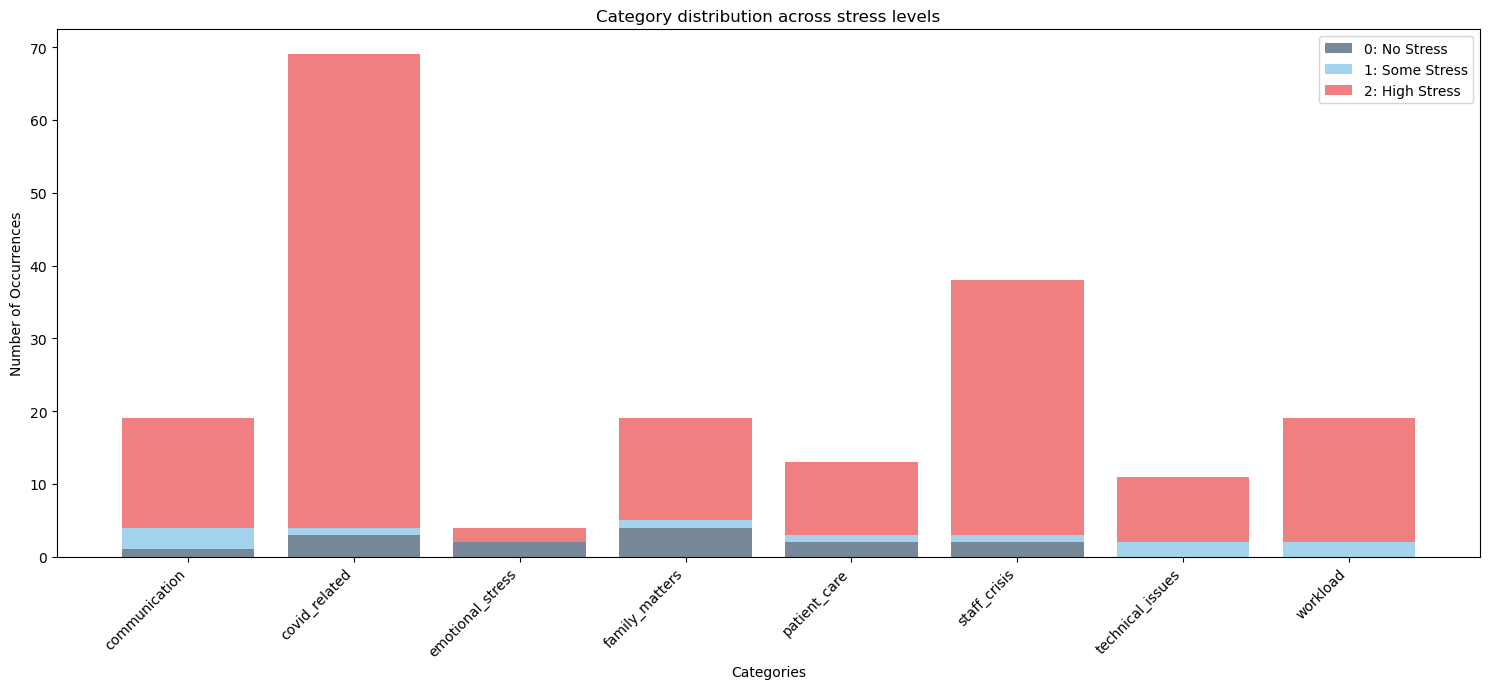

In [56]:
# A stacked bar plot of category distribution by stress level
plt.figure(figsize=(15, 7))

# getting all unique categories
all_categories = sorted(overall_counts.keys())

# creating data for stacked bars
stress_data = {level: [] for level in stress_levels}
for category in all_categories:
    for level in stress_levels:
        level_df = df[df['stress_level'] == level]
        count = sum(1 for cats in level_df['categories'] if category in cats)
        stress_data[level].append(count)

# creating the stacked bar chart
bottom = np.zeros(len(all_categories))
for level in stress_levels:
    plt.bar(all_categories, stress_data[level], bottom=bottom, 
            label=stress_level_names[level],
            color=stress_level_colors[level])
    bottom += stress_data[level]

plt.xticks(rotation=45, ha='right')
plt.title('Category distribution across stress levels')
plt.xlabel('Categories')
plt.ylabel('Number of Occurrences')
plt.legend()
plt.tight_layout()
plt.show()